In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc
from sklearn.model_selection import train_test_split
from scripts.proj1_helpers import create_csv_submission, load_csv_data

seed = 9
np.random.seed(seed)

# Preprocessing

### The very first step in every data science pipeleine is loading the data and spliting it on the train/val/test holdouts

In [2]:
with open("data/test.csv", "r") as f:
    columns = f.readline().split(",")[2:]

y_test, X_test, ids_test = load_csv_data('data/test.csv')
y_dev, X_dev, ids_dev = load_csv_data('data/train.csv')

### Check if we need to drop some rows from dev set since thay are identical

In [3]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

np.all(X_dev.shape == unique_rows(X_dev).shape)

True

As we can see there is no identical rows in dataset.

### We will split `dev` dataset on train and validation datasets with ratio 80 : 20 respectively.
Starting by directly separating the data we will work on into distinct training and validation sets limits from the start the risk of creating dependencies bewteen the sets and therefore influencing our validation set to a much higher accuracy than what we should expect. Keeping separate the transformations done on the training and validation sets avoids us from no longer accurately measuring how well our models generalize to new data found in the validation set. Categorical variables will have a binary outcome of 0 or 1.

In [4]:
ratio = 0.8
num_row = X_dev.shape[0]
indices = np.random.permutation(num_row)
    
index_split = int(np.floor(ratio * num_row))
index_train = indices[: index_split]
index_val = indices[index_split:]

# split
y_train, X_train, ids_train = y_dev[index_train], X_dev[index_train], ids_dev[index_train]
y_val, X_val, ids_val = y_dev[index_val], X_dev[index_val], ids_dev[index_val]

### Lets check if `val` and `test` datasets have the same distributions of features.

Visualizing the data is important to give us an idea of how it should be used, pinpointing the right direction to take and helps us analyzing it. Visualising certain columns within the data assists us to further understand the meaning of each feature, whether it is categorical or continuous and if a variable is independant or not.

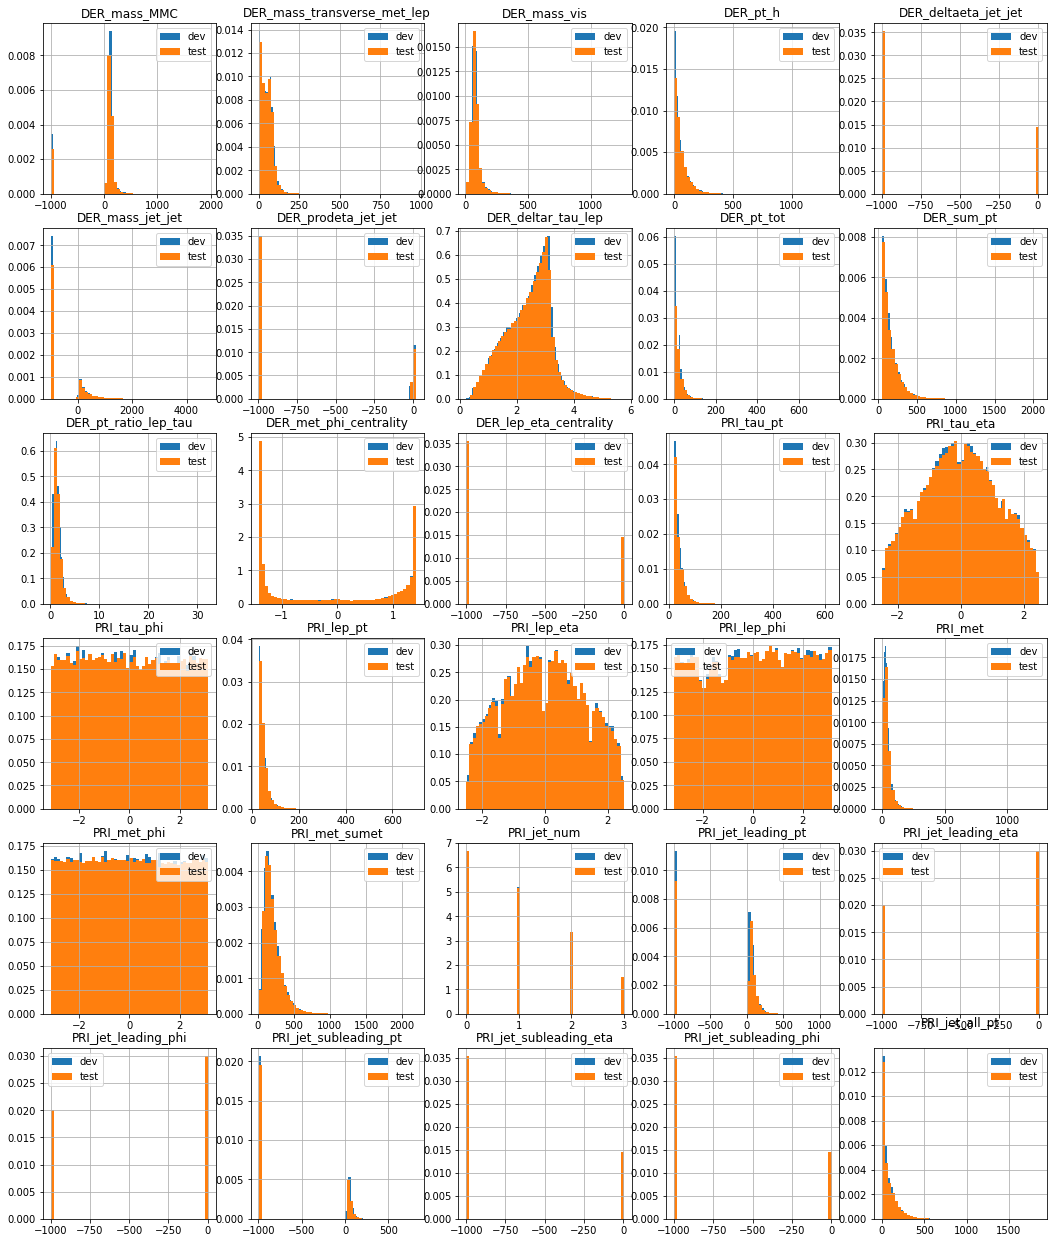

In [5]:
fig, axs = plt.subplots(6, 5, figsize=(18,22))
for i in range(X_dev.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_val[:, i],
        bins=50, 
        density=True, 
        label="dev"
    )
    ax.hist(
        X_test[:, i],
        bins=50, 
        density=True, 
        label="test"
    )
    ax.set_title(columns[i])
    ax.legend()
    ax.grid()

Features distribution is quite similar. Moreover, as we can see fratures `PRI_tau_phi` and `PRI_met_phi` are approximately uniformly distributed. To deside whether we want to drop a feature we need to understand if this feature brings usefull information to the models' predictions. To test this we will train a classifier that predicts the feature value from all the other features, including target.

In [6]:
from implementations import (
    least_squares, 
    least_squares_GD, 
    least_squares_SGD,
    ridge_regression, 
    reg_logistic_regression, 
    logistic_regression, 
    sigmoid,
    compute_loss
)

unifrom_features_ids = [15, 18, 20]

In [7]:
for feature_id in unifrom_features_ids:
    y_feature_selection = X_train[:, feature_id]
    X_feature_selection = np.concatenate([X_train[:, :feature_id], X_train[:, feature_id + 1:], y_train.reshape(-1, 1)], axis=-1)
    _, w = ridge_regression(y_feature_selection[:-30000], X_feature_selection[:-30000], lambda_=0.1)
    mse = compute_loss(y_feature_selection[-30000:], X_feature_selection[-30000:], w)
    r = 1 - mse / y_feature_selection.std()
    print(f"feature {feature_id}, r^2: {r}")

feature 15, r^2: 0.15381684436606502
feature 18, r^2: 0.16041475871705912
feature 20, r^2: 0.12398437762457759


It seems that these features contain very little amout of usefull information, in this regard, we will drop them. 

In [8]:
X_train = np.delete(X_train, [15, 18, 20], axis=1)
X_val = np.delete(X_val, [15, 18, 20], axis=1)
X_test = np.delete(X_test, [15, 18, 20], axis=1)

### Next, we will build a correlation matrix of the features to determine if we have a correlated features.
We will plot the data's correlation matrix to identify highly correlated features. The correlation measures the association between two variables, when features are highly correlated, the variance of the weight matrix will be large, which isn't beneficial for prediction due to overfitting. Therefore, we must remove highly correlated features and only keep one of the two. We used a threshold value of 0.95, all the correlation values over 0.95 or under -0.95 will be removed.

<AxesSubplot:>

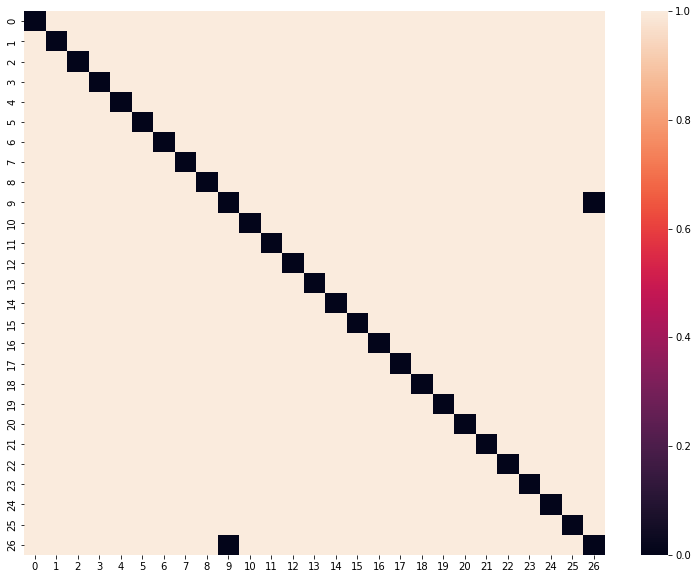

In [9]:
X_train_for_corr = np.where(X_train < -998.0, np.nan, X_train)
corr_matrix = pd.DataFrame(X_train_for_corr).corr().values
plt.figure(figsize=(13, 10))
sns.heatmap((corr_matrix < 0.95) & (-0.95 < corr_matrix))

There are only few highly correlated features, we can delete one of the two correlated features in our training, validation and test sets.

In [10]:
cor_features_ids = [pair for pair in np.argwhere((corr_matrix >= 0.95) | (-0.95 >= corr_matrix)) if pair[0] != pair[1]][::2]

In [11]:
ids_to_delete = [pair[0] for pair in cor_features_ids]
X_train = np.delete(X_train, ids_to_delete, axis=1)
X_val = np.delete(X_val, ids_to_delete, axis=1)
X_test = np.delete(X_test, ids_to_delete, axis=1)

### Getting rid of NAN values
As we can see from the histogram plots, many features contain -999 values. These values, being much smaller than other points, can be interpreted as outliers. Outliers distort the trained models and strongly increase their variability, which should be avoided to have a better performance when we use our model on another data set. We will therefore replace them with the average value of the corresponding feature.

In [12]:
for i in range(X_train.shape[1]):
    features = X_train[:, i]
    mean = features[features >= -998.0].mean()
    X_train[:, i] = np.where(X_train[:, i] < -990.0, mean, X_train[:, i])
    X_val[:, i] = np.where(X_val[:, i] < -990.0, mean, X_val[:, i])
    X_test[:, i] = np.where(X_test[:, i] < -990.0, mean, X_test[:, i])

### Since we plan to use the logistic regression method lets check how the features correlate with the target.

Feature engineering uses knowledge and the plots to select and transform the most relevant variables from raw data to create new features that fit better the machine learning algorithme. Our goal is to find an effective and reliable predictive relationship between an available set of features and an outcome, a way to do this is to transform and optimize our features to the method used. Feature engineering helps uncover hidden patterns in the data to boost the predictive power of machine learning.

<AxesSubplot:>

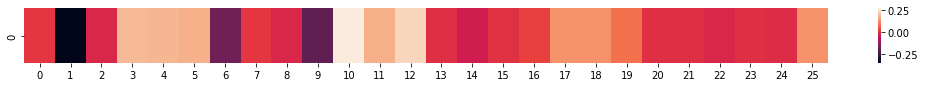

In [13]:
X_train_normalized = X_train / np.linalg.norm(X_train)
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix_old = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(corr_matrix_old[-1, :-1].reshape(1, -1))

### Next we will transform features using log transformation to obtain features that are more correlated with the target.
Through the histograms, we can easily identify which plots do not follow the ideal bell shaped curve, meaning which features are not evenly distributed. This is the case for 10 features, to which we apply a log transformation to make it as normally distributed as possible. This removes the skewness of the original data and thus makes the statistical analysis from these points more valid.

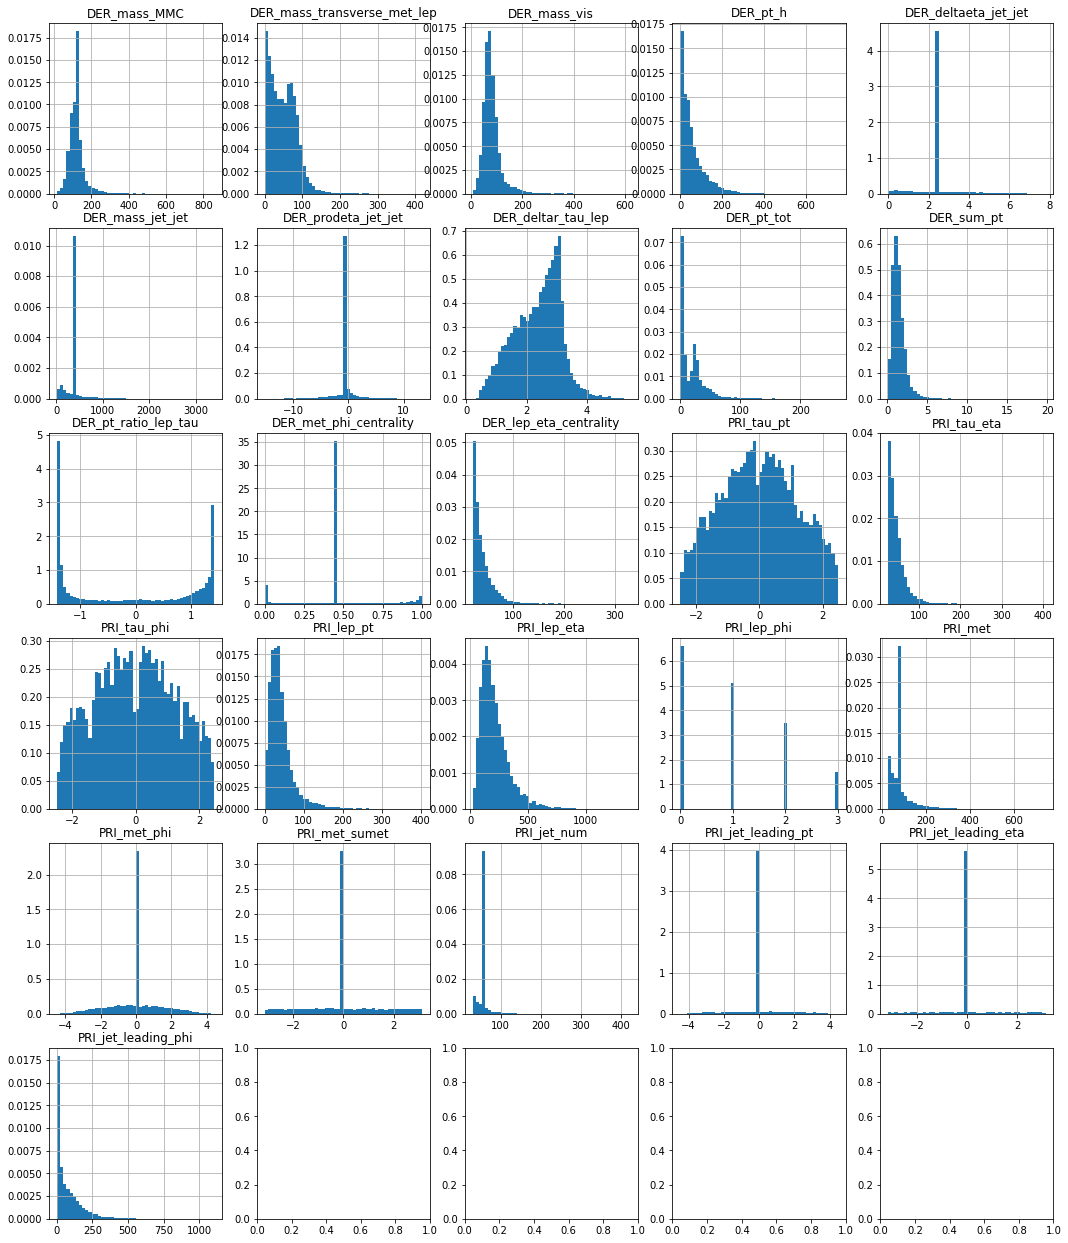

In [14]:
fig, axs = plt.subplots(6, 5, figsize=(18,22))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:10000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])
    ax.grid()

In [15]:
for i in [
    3, 8, 9, 12, 14, 16, 17, 19, 22, 25
]:
    X_train[:, i] = np.log(X_train[:, i] -  X_train[:, i].min() + 1e-10)
    X_val[:, i] = np.log(X_val[:, i] -  X_val[:, i].min() + 1e-10)
    X_test[:, i] = np.log(X_test[:, i] -  X_test[:, i].min() + 1e-10)

<AxesSubplot:>

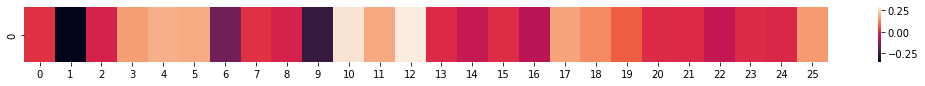

In [16]:
X_train_normalized = X_train / np.linalg.norm(X_train)
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(corr_matrix[-1, :-1].reshape(1, -1))

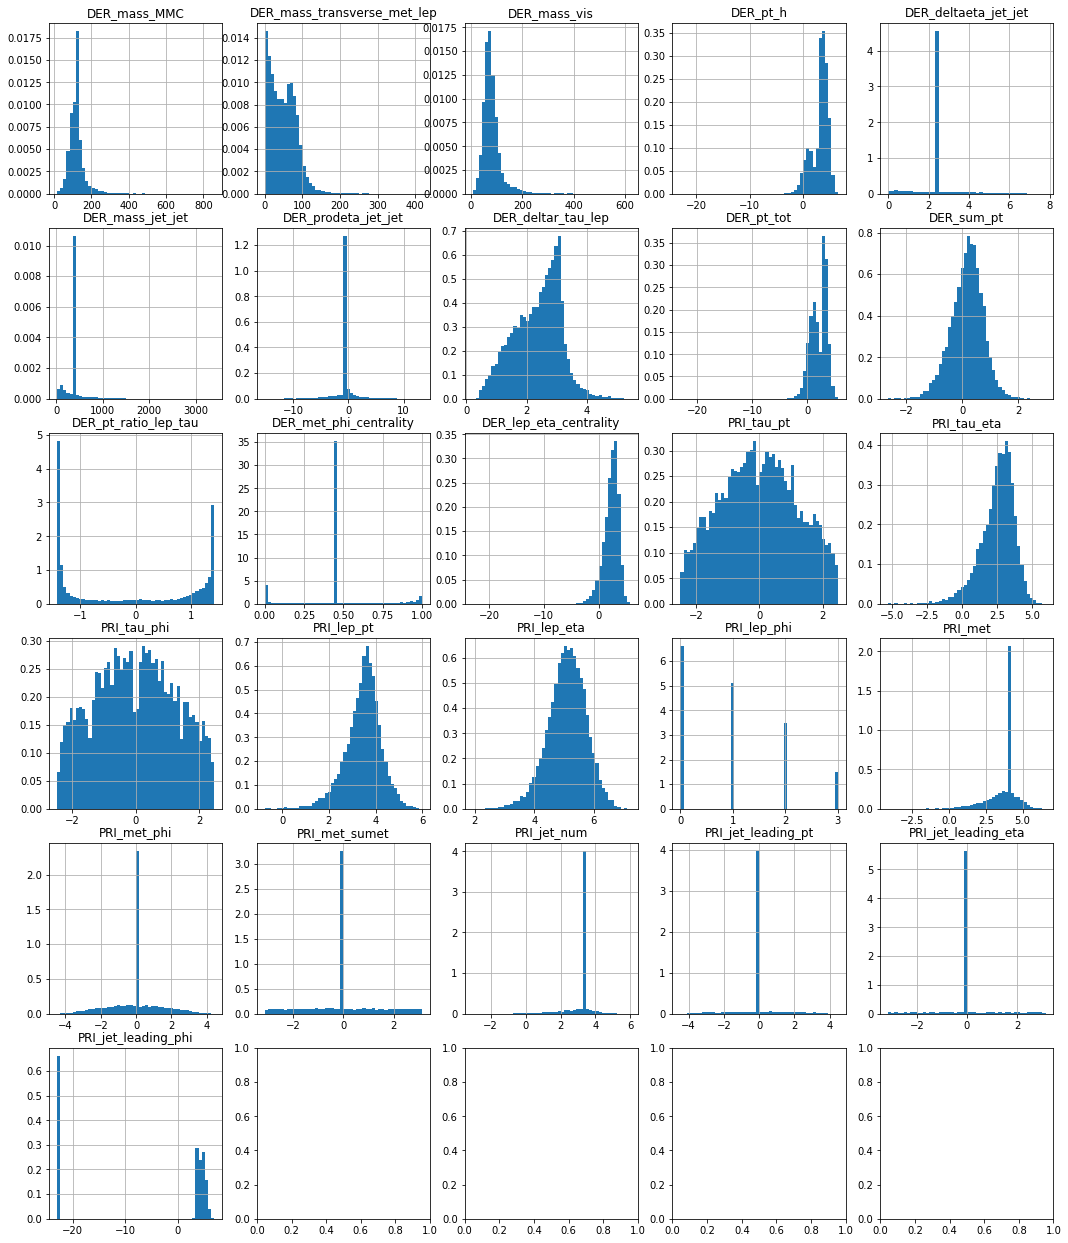

In [17]:
fig, axs = plt.subplots(6, 5, figsize=(18,22))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:10000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])
    ax.grid()

### Since our features has very diverse values it could be usefull to standerdize them. Since we are using linear models extraction of `mean` and division on `std` should not affect the final performance
Standardization is interesting when features have large differences between their ranges, or measured in different units. Having standardized data will be helpful when implementing our methods, especially for the penality applied by ridge regression since the scale of variables affects how much penalty is applied on their coefficients. We use the Z-score to standardize the data, done by subtracting the mean and dividing by the standard deviation for each value of each feature. Since we are using linear models these computations should not affect the final performance of the models.

In [18]:
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
X_val = (X_val - mean) / std

### Next, we observe is that `PRI_met_sumet` is a categorical feature, having 4 distinct values. In this regard, we create 4 corresponding features representing each state.
To do so we use one hot encoding to convert this categorical feature into a numerical one, each of the four category values are assigned to an integer value designing to which category a given point belongs.

In [19]:
X_train_categorial = X_train[:, 18]
X_train_new_features = np.zeros((X_train.shape[0], 4))
X_train = np.delete(X_train, 18, axis=1)

X_val_categorial = X_val[:, 18]
X_val_new_features = np.zeros((X_val.shape[0], 4))
X_val = np.delete(X_val, 18, axis=1)

X_test_categorial = X_test[:, 18]
X_test_new_features = np.zeros((X_test.shape[0], 4))
X_test = np.delete(X_test, 18, axis=1)

vals = np.unique(X_val_categorial)

for i, v in enumerate(vals):
    X_train_new_features[:, i] = np.where(X_train_categorial == v, 1, 0)
    X_val_new_features[:, i] = np.where(X_val_categorial == v, 1, 0)
    X_test_new_features[:, i] = np.where(X_test_categorial == v, 1, 0)
    
X_train = np.concatenate([X_train, X_train_new_features], axis=-1)
X_val = np.concatenate([X_val, X_val_new_features], axis=-1)
X_test = np.concatenate([X_test, X_test_new_features], axis=-1)

### We also need to add a bias term to the model, to do so we will add a constant feature to X.

In [20]:
X_train = np.concatenate([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)], axis=-1)
X_val = np.concatenate([X_val, np.ones(X_val.shape[0]).reshape(-1, 1)], axis=-1)
X_test = np.concatenate([X_test, np.ones(X_test.shape[0]).reshape(-1, 1)], axis=-1)

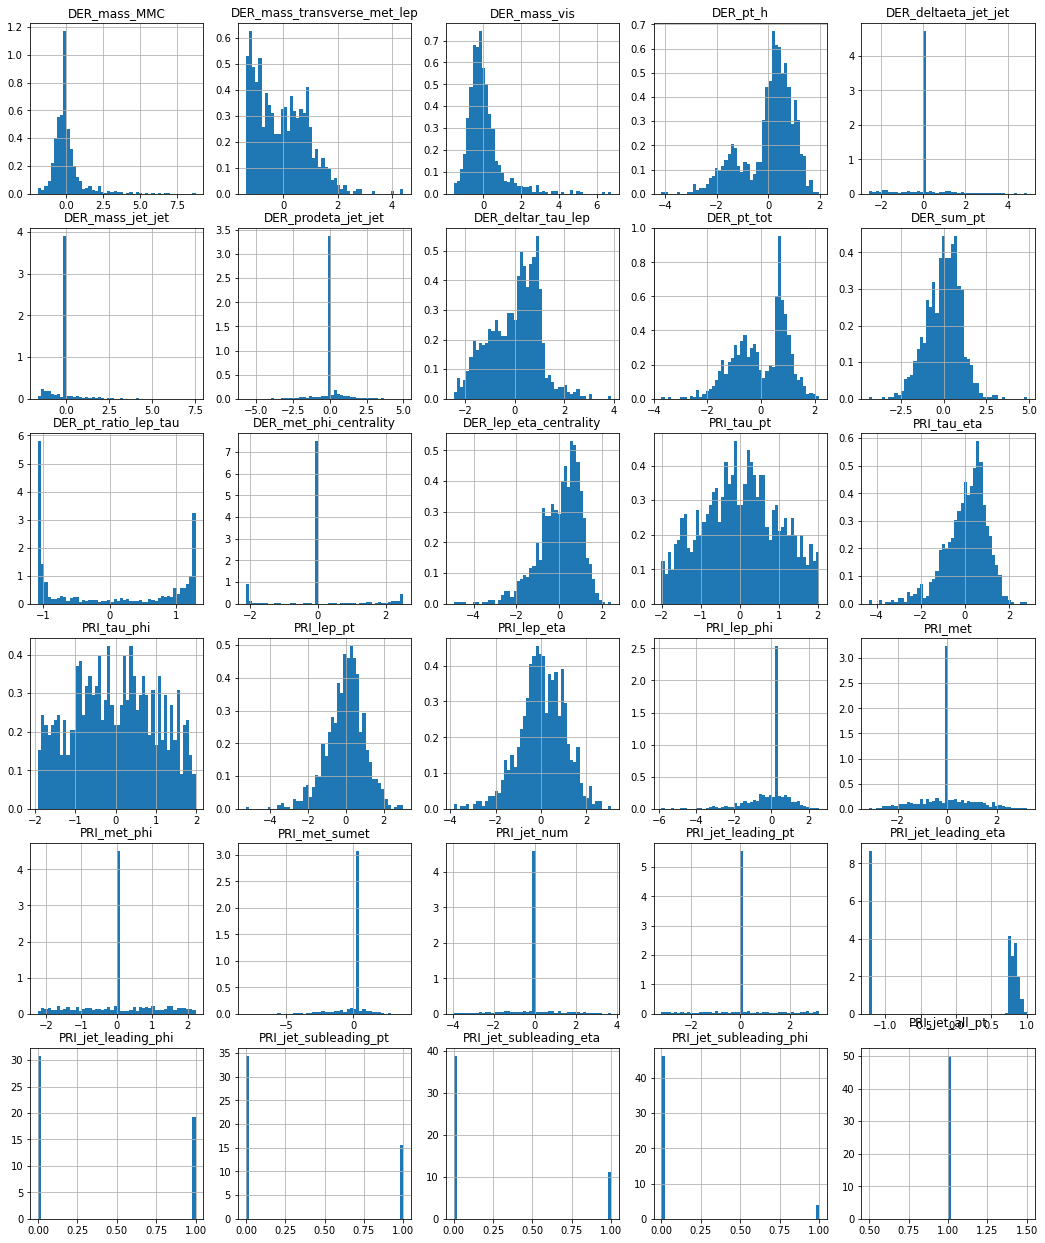

In [21]:
fig, axs = plt.subplots(6, 5, figsize=(18,22))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])
    ax.grid()

### Next we will cut the features by the 0.01 and 0.99 quantiles in order to remove most of the outliers (the point sthat are over and under each quantile).

In [22]:
train_cond = 1
for i in range(24):
    l_bound, u_bound = np.quantile(X_train[:, i], 0.01), np.quantile(X_train[:, i], 0.99) 
    train_cond &= (X_train[:, i] >= l_bound) & (X_train[:, i] <= u_bound)

In [23]:
X_train = X_train[train_cond.astype(bool), :]
y_train = y_train[train_cond.astype(bool)]

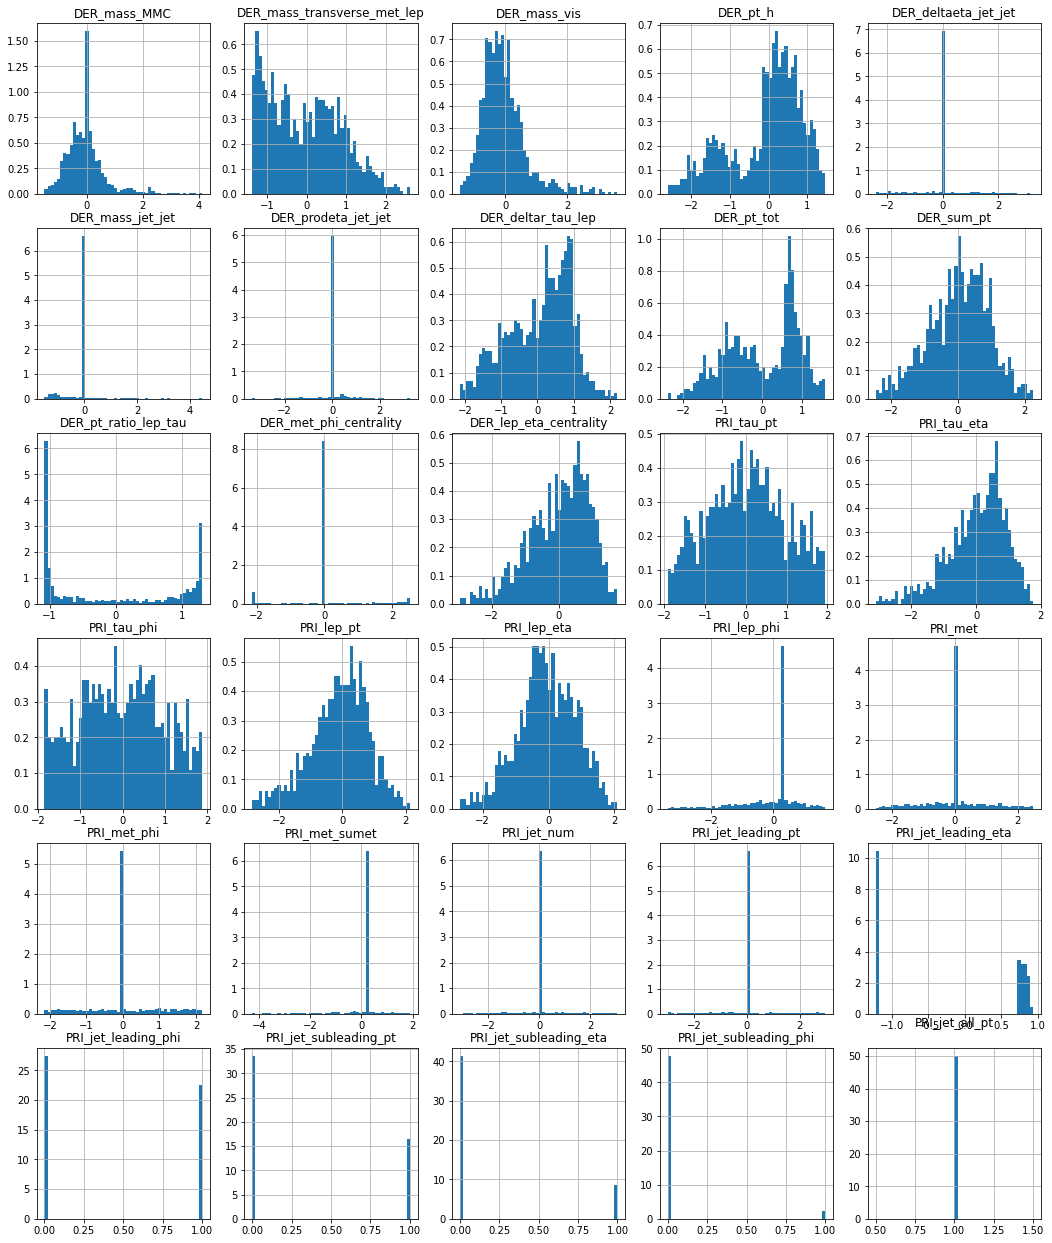

In [24]:
fig, axs = plt.subplots(6, 5, figsize=(18,22))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])
    ax.grid()

# Baseline solution

We will start by testing all the methods we implemented during the project.

In [25]:
from implementations import (
    least_squares, 
    least_squares_GD, 
    least_squares_SGD,
    ridge_regression, 
    reg_logistic_regression, 
    logistic_regression, 
    sigmoid
)

w = {}

In [26]:
_, w["ridge"] = ridge_regression(
    y=y_train, 
    tx=X_train, 
    lambda_=.0001
)

In [27]:
_, w["logistic"] = logistic_regression(
    y=y_train, 
    tx=X_train, 
    w=np.random.normal(size=X_train.shape[-1]), 
    max_iters=50, 
    gamma=0.3
)

In [28]:
_, w["reg_logistic"] = reg_logistic_regression(
    y=y_train, 
    tx=X_train, 
    w=np.random.normal(size=X_train.shape[-1]), 
    max_iters=50, 
    gamma=0.3, 
    lambda_=.1
)

In [29]:
_, w["least_squares"] = least_squares(
    y=y_train, 
    tx=X_train
)

In [30]:
_, w["least_squares_GD"] = least_squares_GD(
    y=y_train, 
    tx=X_train, 
    initial_w=np.random.normal(size=X_train.shape[-1]), 
    gamma=0.3,
    max_iters=50, 
)
_, w["least_squares_SGD"] = least_squares_SGD(
    y=y_train, 
    tx=X_train, 
    gamma=0.3,
    initial_w=np.random.normal(size=X_train.shape[-1]), 
    max_iters=100, 
    batch_size=1000,
)

### Lets plot the ROC curves to visualize each model's performance:

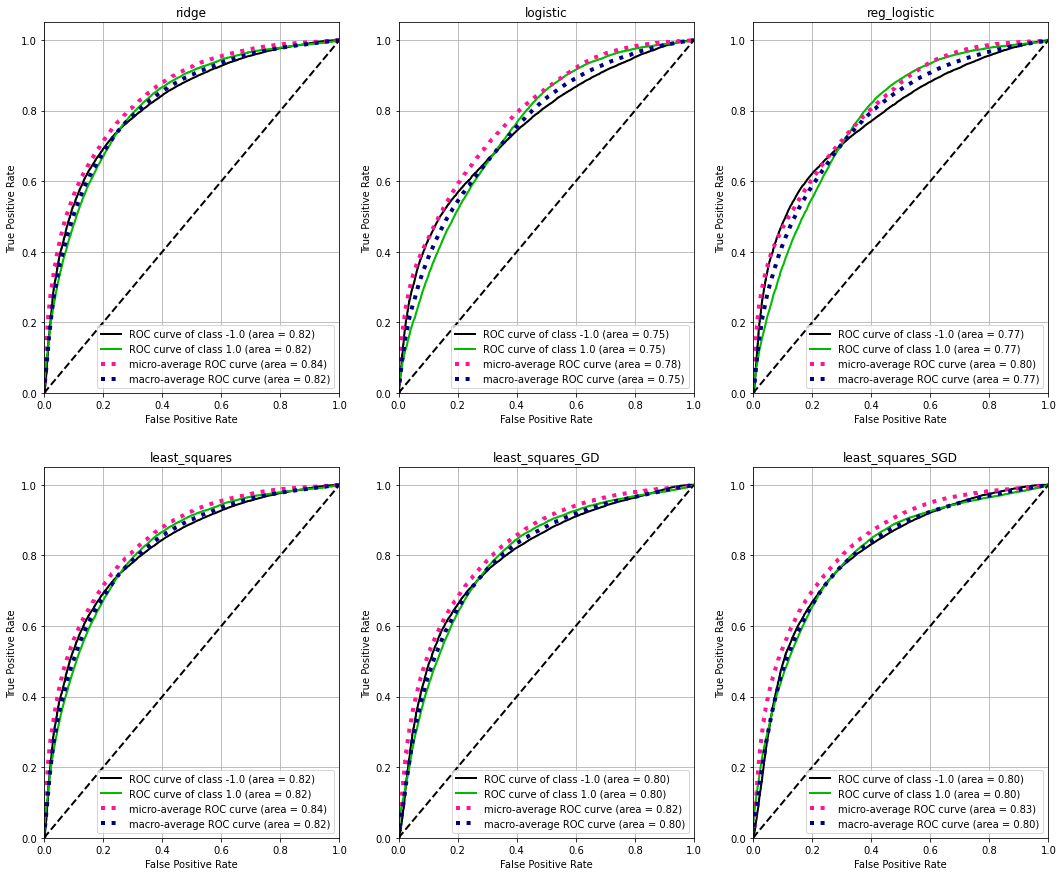

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(18,15))
for i, (k, v) in enumerate(w.items()):
    ax = axs[i // 3, i % 3]
    y_pred = (sigmoid(X_val @ v)).reshape(-1, 1)
    plot_roc(y_val, np.concatenate([1 - y_pred, y_pred], axis=1), ax=ax)
    ax.set_title(k)
    ax.grid()

### Seems like the best model is ridge regression.

### As a final step we will add second degree $x_i^2$ of each feature, and cross-features products $x_i x_j$. With additional features, the expressibility of the model will increase since it will be possible to approximate not only linear functions but also second-degree polynomials.

In [32]:
from itertools import combinations

X_train = np.concatenate([
    X_train, X_train[:, :-1] ** 2
] + [
    (X_train[:, i] * X_train[:, j]).reshape(-1, 1) for i, j in combinations(range(X_train.shape[1] - 5), r=2)
], axis=-1)

X_val = np.concatenate([
    X_val, X_val[:, :-1] ** 2
] + [
    (X_val[:, i] * X_val[:, j]).reshape(-1, 1) for i, j in combinations(range(X_val.shape[1] - 5), r=2)
], axis=-1)

X_test = np.concatenate([
    X_test, X_test[:, :-1] ** 2
] + [
    (X_test[:, i] * X_test[:, j]).reshape(-1, 1) for i, j in combinations(range(X_test.shape[1] - 5), r=2)
], axis=-1)

### Now, lets tune the hyperparameters using cross-validation and choose the best value for the threshold.
Ridge regression's hyperparameter  𝜆  can be tuned using cross validation to have the best possible accuracy using this method. As  𝜆  gets larger, the model's variance will decrease which makes it more reliable for classification on new data sets, however we should be careful not to reduce the variance too much and fall into underfitting, which is where cross validation comes in handy.

In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
from implementations import build_k_indices, build_poly, calculate_mse
from metrics import accuracy, f1, roc_auc

def cross_validation(y, x, test_ids, lambda_):
    test_index = k_indices[k]
    
    x_test = x[test_ids]
    y_test = y[test_ids]
    x_train = np.delete(x, test_ids, axis=0)
    y_train = np.delete(y, test_ids, axis=0)

    _, w = ridge_regression(y_train, x_train, lambda_)
    y_pred = sigmoid(x_test @ w)

    return roc_auc_score(y_test, y_pred)

In [35]:
from tqdm import tqdm

k_fold = 5
lambdas = np.logspace(-16, 1, 100)
k_indices = build_k_indices(y_train, k_fold, seed)

roc_aucs = {}

for lambda_ in tqdm(lambdas):
    roc_auc_lambda = []
    for k in range(k_fold):
        test_ids = k_indices[k]
        roc_auc_ = cross_validation(y_train, X_train, test_ids, lambda_)
        roc_auc_lambda.append(roc_auc_)
    roc_aucs[lambda_] = np.mean(roc_auc_lambda)

100%|█████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]


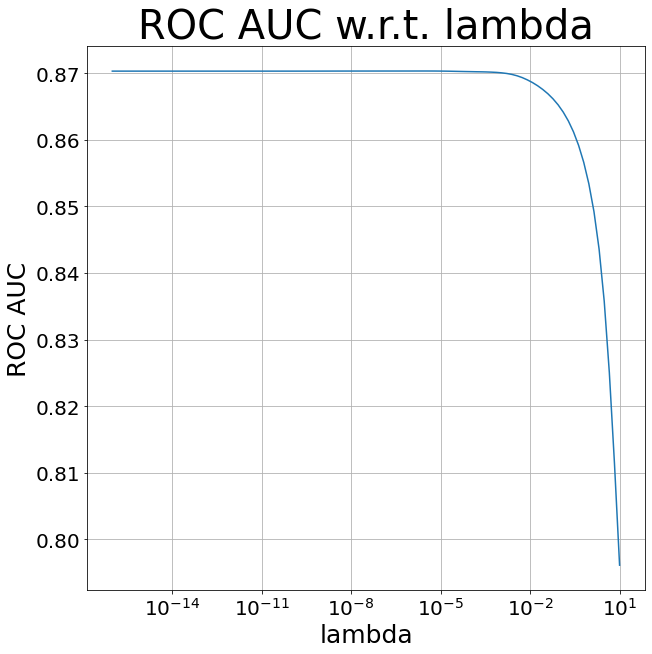

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(lambdas, [v for k, v in roc_aucs.items()])
plt.title('ROC AUC w.r.t. lambda', fontsize=40)
plt.ylabel('ROC AUC', fontsize=25)
plt.xlabel('lambda', fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

In [37]:
best_lambda = lambdas[np.argmax([v for k, v in roc_aucs.items()])]
print(f"The best lambda is {best_lambda}")

The best lambda is 2.983647240283334e-06


Logistic regression returns the probability of a point to belong to one specific class. In order to map a logistic regression value to a binary category, a classification threshold has to be defined where values above that threshold indicates will be assigned to the first category and a value below to the second. A threshold isn't alwasy 0.5, it's value depends on the problem, and should therefore be tuned. This is what we do below.

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1458.20it/s]


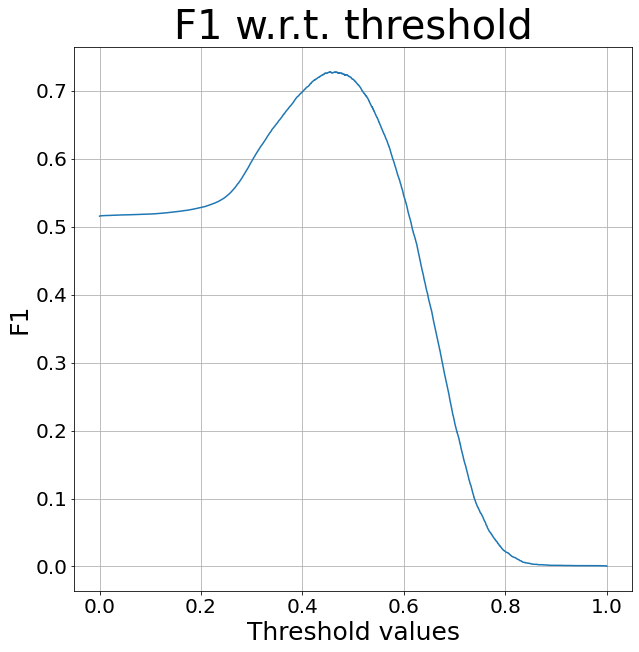

In [38]:
from tqdm import tqdm 

_, w = ridge_regression(y_train, X_train, lambda_=best_lambda)
y_pred = sigmoid(X_val @ w)

tr = np.linspace(0.000001, 0.999999, 10000)
f1s = []
for t in tqdm(tr):
    f1s.append(f1(np.where(y_pred < t, 0, 1), np.where(y_val == -1, 0, 1)))
best_tr = tr[np.argmax(f1s)]
plt.figure(figsize=(10, 10))
plt.plot(tr, f1s)
plt.xlabel("Threshold values", fontsize=25)
plt.ylabel("F1", fontsize=25)
plt.title("F1 w.r.t. threshold", fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

In [39]:
print(f"The best threshold is {best_tr}")

The best threshold is 0.45444553565356527


### Final training of the best model on the full training set with both train and validation sets combined together.

In [40]:
OUTPUT_PATH = 'results.csv'
_, w = ridge_regression(
    np.concatenate([y_train, y_val], axis=0),
    np.concatenate([X_train, X_val], axis=0), 
    lambda_=best_lambda
)
y_pred = np.where(sigmoid(X_test @ w) < best_tr, -1, 1)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)